In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

2025-06-06 13:28:16.655644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749216496.683094     318 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749216496.690927     318 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
dataset_path = r'/kaggle/input/plantdisease/PlantVillage'
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
classes_count = {}
total_count = 0
for clas in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path,clas)
    
    if os.path.isdir(class_path):
        classes_count[clas] = len(os.listdir(class_path))
        total_count += classes_count[clas]
    

for clas,cnt in classes_count.items():
    print(f'{clas} : {cnt} images.' )

print('Total number of images: ',total_count)
print('Total number of classes: ', len(classes_count))

Pepper__bell___Bacterial_spot : 997 images.
Potato___healthy : 152 images.
Tomato_Leaf_Mold : 952 images.
Tomato__Tomato_YellowLeaf__Curl_Virus : 3209 images.
Tomato_Bacterial_spot : 2127 images.
Tomato_Septoria_leaf_spot : 1771 images.
Tomato_healthy : 1591 images.
Tomato_Spider_mites_Two_spotted_spider_mite : 1676 images.
Tomato_Early_blight : 1000 images.
Tomato__Target_Spot : 1404 images.
Pepper__bell___healthy : 1478 images.
Potato___Late_blight : 1000 images.
Tomato_Late_blight : 1909 images.
Potato___Early_blight : 1000 images.
Tomato__Tomato_mosaic_virus : 373 images.
Total number of images:  20639
Total number of classes:  15


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


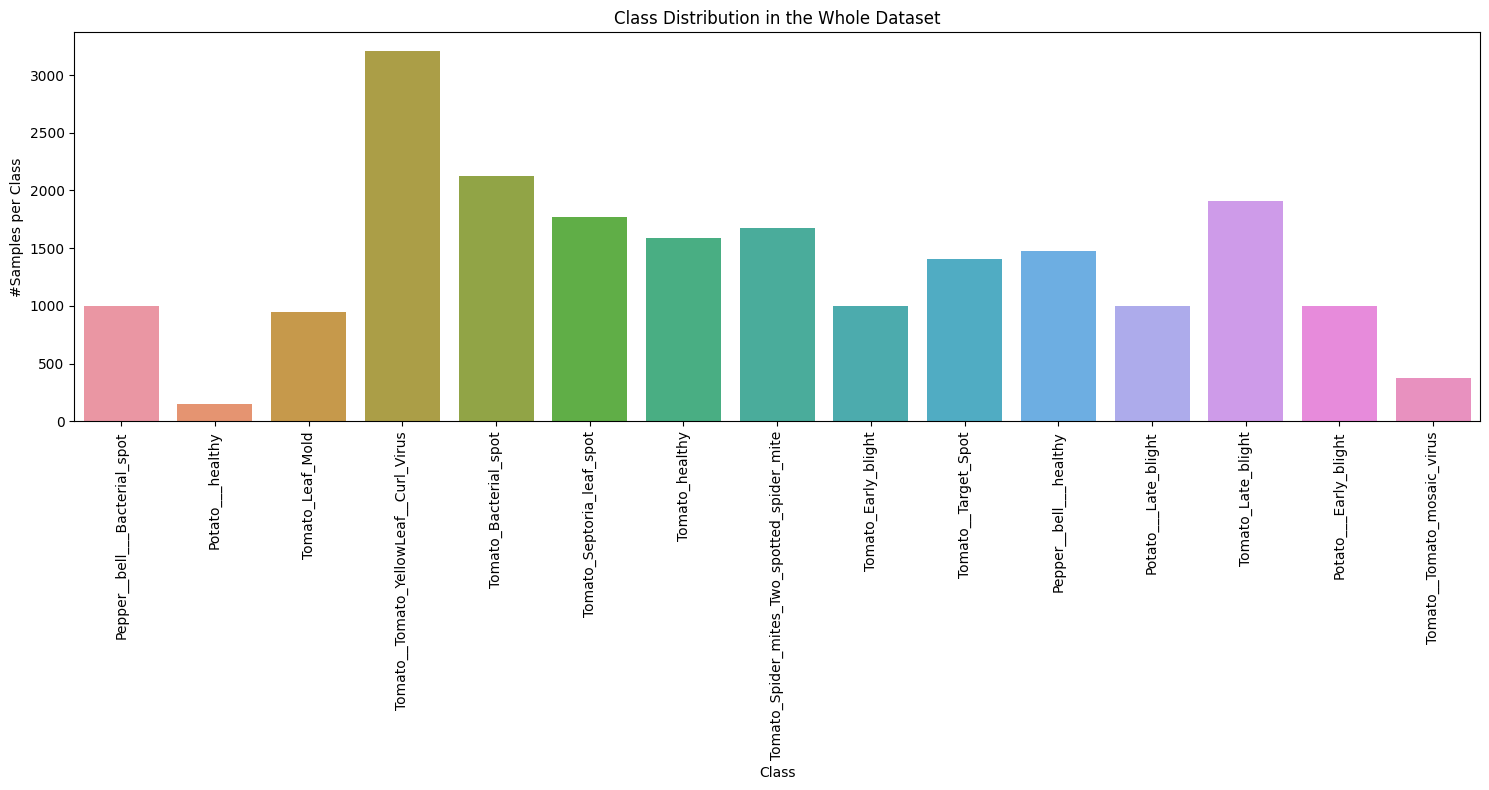

In [5]:
plt.figure(figsize=(15,8))
sns.barplot(x=list(classes_count.keys()), y=list(classes_count.values()))
plt.title('Class Distribution in the Whole Dataset')
plt.xticks(rotation = 90)
plt.xlabel('Class')
plt.ylabel('#Samples per Class')
plt.tight_layout()
plt.show()

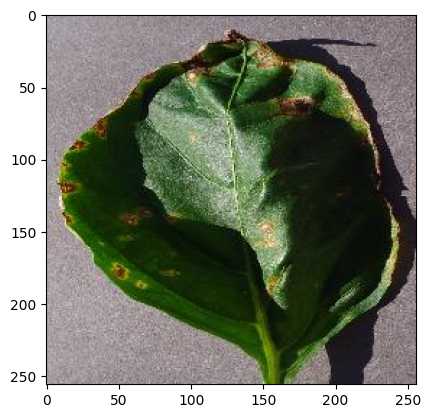

In [6]:
first_class_path = os.path.join(dataset_path,os.listdir(dataset_path)[0])
sample_path = os.path.join(first_class_path,os.listdir(first_class_path)[0])


img = image.load_img(sample_path)
plt.imshow(img)

In [7]:
image_size = (224, 224)
batch_size = 32

In [8]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80% training, 20% validation
)

# Load training data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load validation data
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [9]:
# Use MobileNetV2 as the base model
from tensorflow.keras.applications import MobileNetV2

weights_path = '/kaggle/input/d/surya573/mobilenet/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'

base_model = MobileNetV2(weights=weights_path, include_top=False, input_shape=(224, 224, 3))

2025-06-06 13:28:22.305665: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,585,103 (13.68 MB)

 Trainable params: 1,327,119 (5.06 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# Define callbacks
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Use .keras extension
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.5146 - loss: 1.5782
Epoch 1: val_accuracy improved from -inf to 0.80566, saving model to best_model.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 594s 1s/step - accuracy: 0.5149 - loss: 1.5773 - val_accuracy: 0.8057 - val_loss: 0.6017
Epoch 2/20
  1/516 ━━━━━━━━━━━━━━━━━━━━ 5:49 679ms/step - accuracy: 0.6875 - loss: 0.8744

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.80566 to 0.82031, saving model to best_model.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 115s 223ms/step - accuracy: 0.6875 - loss: 0.8744 - val_accuracy: 0.8203 - val_loss: 0.5889
Epoch 3/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.7819 - loss: 0.6725
Epoch 3: val_accuracy improved from 0.82031 to 0.83398, saving model to best_model.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 579s 1s/step - accuracy: 0.7819 - loss: 0.6724 - val_accuracy: 0.8340 - val_loss: 0.4965
Epoch 4/20
  1/516 ━━━━━━━━━━━━━━━━━━━━ 5:56 692ms/step - accuracy: 0.7812 - loss: 0.5617
Epoch 4: val_accuracy improved from 0.83398 to 0.84668, saving model to best_model.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 113s 218ms/step - accuracy: 0.7812 - loss: 0.5617 - val_accuracy: 0.8467 - val_loss: 0.4761
Epoch 5/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.8219 - loss: 0.5401
Epoch 5: val_accuracy improved from 0.84668 to 0.87305, saving model to best_model.keras
516/516 ━━━━━━━━━

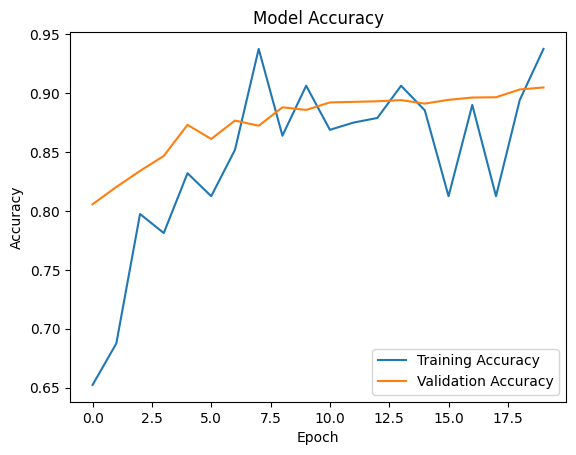

129/129 ━━━━━━━━━━━━━━━━━━━━ 115s 885ms/step - accuracy: 0.8888 - loss: 0.3086
Validation Loss: 0.30533701181411743
Validation Accuracy: 0.8932557106018066


In [13]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

In [14]:
# Save the trained model
model.save('crop_disease_model.keras')
model.save('crop_disease_model.h5')# Use .keras extension

# Load the model for predictions
from tensorflow.keras.models import load_model
loaded_model = load_model('crop_disease_model.keras')

# Example: Predict on a new image
from tensorflow.keras.preprocessing import image

def predict_disease(image_path):
    img = image.load_img(image_path, target_size=image_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = loaded_model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    class_label = list(train_generator.class_indices.keys())[predicted_class[0]]
    return class_label

# Test the function
image_path = "/kaggle/input/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG"
print(f"Predicted Disease: {predict_disease(image_path)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Disease: Pepper__bell___Bacterial_spot
